<a href="https://colab.research.google.com/github/ChaithanyaSaiB/UMBC-DATA606-Capstone/blob/main/notebooks/Exploration_and_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration and Topic Modeling

## Necessary Imports

This section includes all the packages necessary for execution of the notebook

In [4]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import joblib

## Load Data and Exploration

### Load Preprocessed Data

> **Note**: Data being loaded here is the same one saved at the end of "Data Creation" notebook

In [2]:
# Load the preprocessed data
data = pd.read_csv('/content/combined_preprocessed.csv')

### Word Cloud Plot

Word cloud plot shown below shows all the most frequently occuring words in the dataset with size of each text representing the frequency where high frequency words are larger than less frequency words

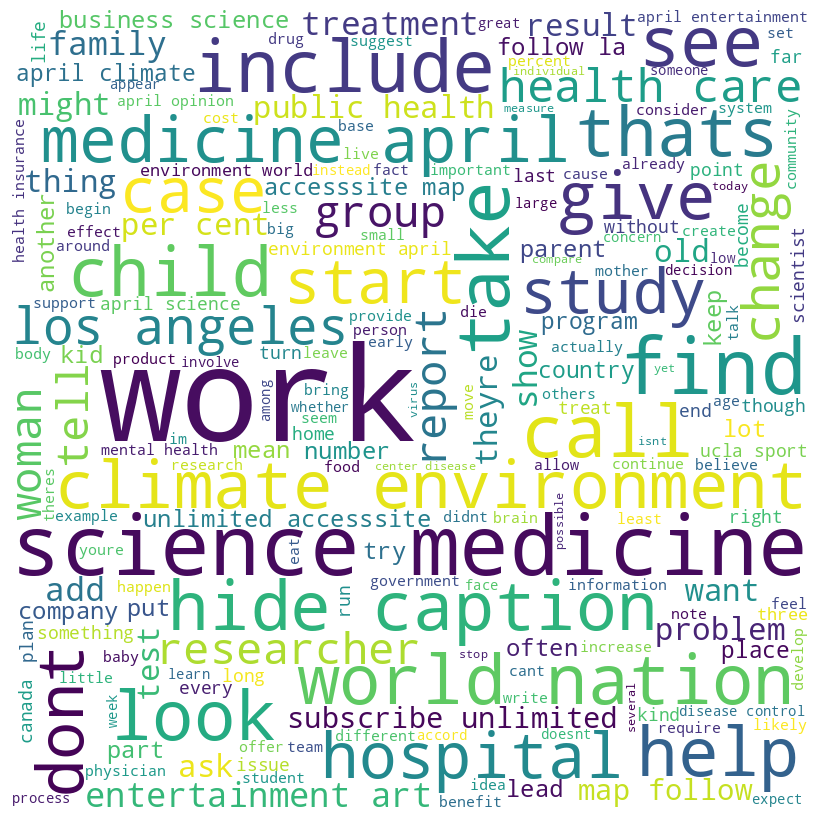

In [7]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(data['Content'].str.cat(sep=' '))

# Plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Topic Modeling

### Vectorizing Data

We initially drop some NAs. Then vectorize the data using TFIDF vectorizer and also tokenize, create dictionary along with corpus from tokenized documents

In [3]:
# Dropping some NAs in the dataset
data.dropna(axis=0, inplace=True)

In [5]:
# Vectorize the text data
vectorizer = TfidfVectorizer()
data_transformed = vectorizer.fit_transform(data['Content'])
data_transformed = pd.DataFrame(data_transformed.toarray(), columns=vectorizer.get_feature_names_out(), index=data.index)

In [6]:
# Tokenize documents
tokenized_documents = [doc.split() for doc in data['Content']]

# Create a dictionary from the tokenized documents
dictionary = corpora.Dictionary(tokenized_documents)

# Create a corpus from the tokenized documents
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

### Deciding Number of Topics

We experiment with number of topics for LDA model and plot the results to come to a conclusion

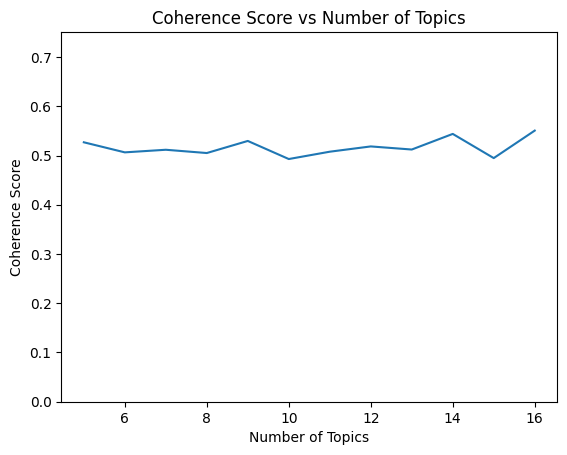

In [7]:
# Set range of topics to explore
min_topics = 5
max_topics = 17
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Run LDA model for different number of topics and compute coherence score
coherence_scores = []
for num_topics in topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1,
                         chunksize=100, passes=4, alpha='auto', per_word_topics=True)
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Plot coherence score vs number of topics
plt.plot(topics_range, coherence_scores)
plt.ylim(0, max(coherence_scores) + 0.2)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

From the plot above, we can notice that number of topics equal to 5 gives almost similar coherence score as higher topics. So we can pick 5 as the number of topics parameter for our model.

### Hyperparameter Optimization

We look for the best model parameters that give highest score. We apply grid wise search technique and give parameters like alpha, eta, passes and chunksize for optimization

In [8]:
params_grid = {
    'alpha': ['auto', 'symmetric', 'asymmetric'],  # Alpha parameter
    'eta': ['auto', 0.01, 0.1],  # Eta parameter
    'passes': [5, 10],  # Number of passes through the corpus
    'chunksize': [100, 200],  # Number of documents to load into memory at a time
}

best_model = None
best_coherence_score = -np.inf  # Initialize best_coherence_score

# Perform grid search with revised parameter combinations
for params in ParameterGrid(params_grid):
    print("Trying parameters:", params)
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, **params, random_state=42)  # Increase num_topics
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print("Coherence Score:", coherence_score)

    # Update best model if coherence score improves
    if coherence_score > best_coherence_score:
        best_model = lda_model
        best_coherence_score = coherence_score

print("Best Model Parameters:", best_model.get_topics())
print("Best Coherence Score:", best_coherence_score)

Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 5}
Coherence Score: 0.5288401699357296
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 10}
Coherence Score: 0.515982031014089
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 0.01, 'passes': 5}
Coherence Score: 0.5198270822521642
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 0.01, 'passes': 10}
Coherence Score: 0.5198270822521642
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 0.1, 'passes': 5}
Coherence Score: 0.5048502894991364
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 0.1, 'passes': 10}
Coherence Score: 0.5005209348277123
Trying parameters: {'alpha': 'auto', 'chunksize': 200, 'eta': 'auto', 'passes': 5}
Coherence Score: 0.49025890510043785
Trying parameters: {'alpha': 'auto', 'chunksize': 200, 'eta': 'auto', 'passes': 10}
Coherence Score: 0.4887752871259174
Trying parameters: {'alpha': 'auto', 'chunksize': 200,

We can notice that best score is achieved at  **alpha** = asymmetric, **chunksize** = 100, **eta** = 0.01, **passes** = 10

### Model Training and Topics

We train the model on the best parameters found above using hyperparameter optimization and extract the topics terms from the trained model. We can derive the topic name from the terms based on existing knowledge on terms in context of health news

In [10]:
# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, update_every=1, chunksize=100, passes=10, alpha='asymmetric', eta=0.01, random_state=42)

# Print topics
pprint(lda_model.print_topics())


[(0,
  '0.021*"health" + 0.015*"california" + 0.012*"nation" + 0.010*"business" + '
  '0.010*"care" + 0.010*"drug" + 0.009*"would" + 0.007*"plan" + '
  '0.006*"medical" + 0.006*"policy"'),
 (1,
  '0.024*"science" + 0.024*"april" + 0.023*"study" + 0.022*"medicine" + '
  '0.013*"researcher" + 0.011*"follow" + 0.010*"environment" + 0.009*"climate" '
  '+ 0.009*"woman" + 0.009*"cancer"'),
 (2,
  '0.015*"entertainment" + 0.013*"art" + 0.012*"sport" + 0.011*"get" + '
  '0.010*"world" + 0.010*"business" + 0.009*"work" + 0.008*"california" + '
  '0.007*"april" + 0.006*"school"'),
 (3,
  '0.021*"world" + 0.019*"virus" + 0.018*"case" + 0.015*"infection" + '
  '0.015*"vaccine" + 0.014*"health" + 0.014*"disease" + 0.014*"flu" + '
  '0.011*"report" + 0.011*"nation"'),
 (4,
  '0.045*"food" + 0.026*"april" + 0.022*"eat" + 0.020*"weight" + '
  '0.015*"editor" + 0.015*"diet" + 0.013*"business" + 0.012*"fat" + '
  '0.011*"product" + 0.011*"drink"')]


**Topics and their keywords**

1. **Healthcare Policy and Business**: This topic seems to cover discussions related to healthcare policies, business implications, and drug-related matters.

2. **Medical Research and Studies**: This topic involves discussions on scientific research, medical studies, environmental factors, and cancer research.

3. **Entertainment and Sports**: This topic appears to include content related to entertainment, sports, work-life balance, and possibly cultural events.

4. **Disease and Public Health**: This topic encompasses discussions about infectious diseases, viruses, vaccinations, and public health reports.

5. **Nutrition and Healthy Living**: This topic revolves around food-related discussions, including healthy eating habits, weight management, diet, and food products.

### Analysis on Topics

We analyse the topic distribution in the dataset and its probabilities

In [11]:
topic_names = [
    "Healthcare Policy and Business",
    "Medical Research and Studies",
    "Entertainment and Sports",
    "Disease and Public Health",
    "Nutrition and Healthy Living"
]


# Calculate document-topic distribution
document_topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]

# Calculate average probabilities for each topic
topic_frequencies = defaultdict(float)
for doc_topics in document_topic_distribution:
    for topic, prob in doc_topics:
        topic_frequencies[topic] += prob

num_documents = len(document_topic_distribution)
topic_frequencies = {topic: freq / num_documents for topic, freq in topic_frequencies.items()}

# Sort topics by frequency
sorted_topic_frequencies = sorted(topic_frequencies.items())
topic_frequencies = [tup[1] for tup in sorted_topic_frequencies]

# Print topic frequencies
for topic, value in zip(topic_names, topic_frequencies):
    print("{} topic has {:.2f} average probability in documents".format(topic, value))

Healthcare Policy and Business topic has 0.23 average probability in documents
Medical Research and Studies topic has 0.27 average probability in documents
Entertainment and Sports topic has 0.29 average probability in documents
Disease and Public Health topic has 0.14 average probability in documents
Nutrition and Healthy Living topic has 0.08 average probability in documents


In [12]:
# Create horizontal bar chart
fig = go.Figure(go.Bar(
    x=topic_frequencies,
    y=topic_names,
    orientation='h'
))

# Customize layout
fig.update_layout(
    title='Topics and their average probabilities',
    xaxis_title='Probabilities',
    yaxis_title='Topics',
    yaxis=dict(autorange='reversed', tickmode='linear')  # Reverse the order of categories for horizontal bar chart
)

# Show plot
fig.show()


Looking at the graph, **Entertainment and Sports** along with **Healthcare Policy and Business** and Medical Research and Studies seem to cover over 80% of probabilities of a article

### Saving Model and Dictionary for App

In [13]:
joblib.dump(lda_model, "lda_model.sav")
dictionary.save('dictionary.sav')